# Inpainting Project

importing libraries we are going to need :

In [1]:
import imageio as iio
import numpy as np
import skimage.morphology as morpho  
from skimage import img_as_float
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
import cv2
import imageio
import os

# Affichage de l'image

In [2]:
def view(data, size=(4, 4), dpi=100):
    """
    Image Dispaly
    """
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(data)
    plt.show()

# Création du masque

In [3]:
def mask_creation(im, x1, x2 , y1 , y2):
    """
    Prend une image et les coordonnées de deux points et retourne un masque rectangulaire 
    de la taille de l'image. La partie masquée contient des 0 et le reste des 1. 
    """
    shape = im.shape
    mask = np.ones((shape[0],shape[1]), dtype=int)
    for i in range(x1,x2):
        for j in range(y1,y2):
            mask[i,j]=0
    return mask


# faite à l'aide de ClaudeIA 

def create_freehand_mask(image, display_scale_factor=1.5, initial_cursor_size=5):
    """
    Permet à l'utilisateur de dessiner un masque à main levée avec un affichage agrandi.
    Le masque et l'image finaux restent à la taille d'origine.
    """
    h, w = image.shape[:2]
    mask = np.ones((h, w), dtype=np.uint8)  # Masque à la taille d'origine

    # Agrandir l'affichage uniquement pour la visualisation
    display_image = cv2.resize(image, (int(w * display_scale_factor), int(h * display_scale_factor)))
    display_mask = np.ones((int(h * display_scale_factor), int(w * display_scale_factor)), dtype=np.uint8)

    # Paramètres du curseur
    cursor_size = initial_cursor_size

    # Fonction de dessin
    def draw_circle(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            param['drawing'] = True
        elif event == cv2.EVENT_MOUSEMOVE:
            if param['drawing']:
                # Adapter les coordonnées du curseur à la taille d'origine
                orig_x, orig_y = int(x / display_scale_factor), int(y / display_scale_factor)
                cv2.circle(mask, (orig_x, orig_y), cursor_size, 0, -1)  # Dessine sur le masque à taille réelle
                cv2.circle(display_mask, (x, y), int(cursor_size * display_scale_factor), 0, -1)  # Dessine sur l'affichage
        elif event == cv2.EVENT_LBUTTONUP:
            param['drawing'] = False

    params = {'drawing': False}
    cv2.namedWindow("Draw Mask")
    cv2.setMouseCallback("Draw Mask", draw_circle, params)

    while True:
        # Afficher l'image avec superposition du masque agrandi
        display_overlay = cv2.addWeighted(display_image, 0.7, cv2.merge([display_mask * 255] * 3), 0.3, 0)
        cv2.imshow("Draw Mask", display_overlay)
        
        # Gestion de la taille du curseur
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):  # Quitter avec 'q'
            break
        elif key == ord('m'):  # Augmenter la taille du curseur
            cursor_size = min(cursor_size + 1, 50)
        elif key == ord('p'):  # Réduire la taille du curseur
            cursor_size = max(cursor_size - 1, 1)
        elif key == 27:  # Échapper pour quitter
            break

    cv2.destroyAllWindows()
    return mask


### Application du masque

In [4]:
def apply_mask(im,mask):
    """
    applique un masque sur une image en multipliant chaque pixel par la valeur du masque (cette opération est faite pour les 3 canaux RGB de l'image)
    """
    n,m,k=im.shape
    new_im = np.zeros((n,m,k),dtype=int)
    for i in range(3):
        new_im[:,:,i]=im[:,:,i]*mask
    return new_im

### Selection du patch

In [5]:
def get_patch(image,p,patch_size):
    """
    retourne un patch de taille patch_size*
    centré en p=(x,y) dans l'image. La taille par défaut est 16*16
    """
    r = patch_size//2
    clip = np.array(image[p[0]-r:p[0]+r+1,p[1]-r:p[1]+r+1])
    return clip 

# Detection de bords

In [6]:
def detection_de_bords(mask):
    new_mask = 1-mask
    #view(new_mask)
    n,m=mask.shape
    strell=morpho.disk(1)
    bords= new_mask-morpho.erosion(new_mask,strell)
    #view(strell)
    L=[]
    for i in range(n):
        for j in range(m):
            if(bords[i,j]==1):
                L.append((i,j))
    return L


def detection_de_bords2(mask):
    """
    On applique un noyau de convolution au masque pour obtenir les points de la frontière (il permet de détecter à chaque 
    point si il y'a au moins un point voisin qui a la valeur 1 ) puis on filtre le résultat pour conserver uniquement les points nuls 
    ayant au moins un voisin 1 ce qui constitue la frontière.
    """
    n,m=mask.shape
    kernel = np.array([[0, 1, 0], 
                       [1, 0, 1], 
                       [0, 1, 0]])
    conv = convolve2d(mask, kernel, mode='same', boundary='fill', fillvalue=0)
    indices_mat = (conv > 0) & (mask == 0)
    L=[]
    for i in range(n):
        for j in range(m):
            if indices_mat[i][j]==1:
                L.append((i,j))
    return L

# Calcul de distance

In [7]:
def distance_patch(patch1 , patch2 , maskpatch):
    """
    prend 2 patchs en argument et retourne la distance euclidienne entre les 2 patchs auquel on applique le masque 
    (qui correspond à la partie occultée du patch ayant la priorité maximale centré sur le point p appartenant au contour)
    la somme est calculée sur les 3 canaux RGB (somme totale = somme canal R + somme canal G + somme canal B)
    """
    patch1 = np.array(patch1).astype(np.uint64)
    patch2 = np.array(patch2).astype(np.uint64)
    d=0
    for i in range(3): 
        d+= np.sum(maskpatch*(patch1[:,:,i]-patch2[:,:,i])**2)
    return d

from skimage.color import rgb2lab

def distance_patch_2(patch1, patch2, maskpatch):
    """
    Prend 2 patchs en argument et retourne la distance euclidienne dans l'espace CIE Lab
    entre les 2 patchs, en appliquant le masque (qui correspond à la partie occultée du patch).
    """
    # Conversion des patchs RGB vers Lab
    patch1 = np.array(patch1).astype(np.uint64)
    patch2 = np.array(patch2).astype(np.uint64)
    patch1_lab = rgb2lab(patch1 / 255.0)  # Normaliser pour rgb2lab
    patch2_lab = rgb2lab(patch2 / 255.0)
    maskpatch = np.expand_dims(maskpatch, axis=-1)
    # Calcul de la distance dans l'espace Lab
    d = np.sum(maskpatch * ((patch1_lab - patch2_lab) ** 2))
    
    return d

def distance_patch3(patch1, patch2, maskpatch):
    """
    Calcule la distance euclidienne entre deux patchs, en revenant au cas noir et blanc
    
    """
    # Conversion des patchs dans l'espace de couleur Lab
    gray_img1 = np.dot(patch1[...,:3], [0.2989, 0.5870, 0.1140])# on transforme l'image en niveaux de gris
    gray_img2 = np.dot(patch2[...,:3], [0.2989, 0.5870, 0.1140])
    gray_matrix1 = np.array(gray_img1)
    gray_matrix2 = np.array(gray_img2)
    # Initialisation de la distance
    d = np.sum(maskpatch * (gray_matrix1 - gray_matrix2)**2)
    return d


# Fonctions Gradient

In [8]:
def gradient_I2(image ,mask, bordure,patch_size):
        """
        Calcul du gradient de l'image en tout point p de la frontière, en transformant l'image en noir et blanc
        """
        h, w = image.shape[:2]
        gray_img = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])  # on transforme l'image en niveaux de gris
        gray_matrix = np.array(gray_img)
        # on remplit la partie masquée de l'image avec des Nan. 
        gray_matrix[mask == 0] = np.nan
        # Calcul du gradient
        fgradx,fgrady = np.array([np.zeros([h, w]),np.zeros([h, w])])
        for point in bordure:
            patch=get_patch(gray_matrix,point,patch_size)
            lenght_patch, width_patch = patch.shape
            gradientR = np.nan_to_num(np.gradient(patch))
            average_gradienX= np.sum(gradientR[0])/(lenght_patch*width_patch)
            average_gradienY= np.sum(gradientR[1])/(lenght_patch*width_patch)
            fgradx[point[0], point[1]] = average_gradienX
            fgrady[point[0], point[1]] = average_gradienY

        return [fgradx,fgrady]

# test autre fonction gradient qui le calcul sur les trois canaux RGB séparément et retourne la moyenne de ces trois gradients
def gradient_I(image, mask, bordure, patch_size):
    '''
    Moyenne de gradient sur tout les canaux
    '''
    h, w = image.shape[:2]
    canal_matrix = np.array(image, dtype=float)
    for i in range(3):
        canal_matrix[:,:,i][mask == 0] = np.nan
    fgradx_R, fgrady_R = np.array([np.zeros([h, w]), np.zeros([h, w])])
    fgradx_G, fgrady_G = np.array([np.zeros([h, w]), np.zeros([h, w])])
    fgradx_B, fgrady_B = np.array([np.zeros([h, w]), np.zeros([h, w])])
    for point in bordure:
        patch = get_patch(canal_matrix, point, patch_size)
        lenght_patch, width_patch = patch.shape[:2]
        gradientR = np.nan_to_num(np.gradient(patch))
        average_gradienX_R = np.sum(gradientR[0][:, :, 0]) / (lenght_patch * width_patch)
        average_gradienY_R = np.sum(gradientR[1][:, :, 0]) / (lenght_patch * width_patch)
        fgradx_R[point[0], point[1]] = average_gradienX_R
        fgrady_R[point[0], point[1]] = average_gradienY_R
        average_gradienX_G = np.sum(gradientR[0][:, :, 1]) / (lenght_patch * width_patch)
        average_gradienY_G = np.sum(gradientR[1][:, :, 1]) / (lenght_patch * width_patch)
        fgradx_G[point[0], point[1]] = average_gradienX_G
        fgrady_G[point[0], point[1]] = average_gradienY_G
        average_gradienX_B = np.sum(gradientR[0][:, :, 2]) / (lenght_patch * width_patch)
        average_gradienY_B = np.sum(gradientR[1][:, :, 2]) / (lenght_patch * width_patch)
        fgradx_B[point[0], point[1]] = average_gradienX_B
        fgrady_B[point[0], point[1]] = average_gradienY_B
    fgradx = (fgradx_R + fgradx_G + fgradx_B) / 3
    fgrady = (fgrady_R + fgrady_G + fgrady_B) / 3
    return [fgradx, fgrady]

def gradient_I3(image ,mask, bordure, patch_size):
        """
        Gradient maximal sur tout les canaux
        """
        h, w = image.shape[:2]
        c=image.copy()
        c_r= img_as_float(c[:,:,0])
        c_g= img_as_float(c[:,:,1])
        c_b= img_as_float(c[:,:,2])
        # We fill the outside of the mask with nones
        c_r[mask == 0] = np.nan
        c_g[mask == 0] = np.nan
        c_b[mask == 0] = np.nan
        # We compute the gradient 
        fgradx,fgrady = np.array([np.zeros([h, w]),np.zeros([h, w])])
        for point in bordure:
            patch_r=get_patch(c_r,point,patch_size)
            patch_g=get_patch(c_g,point,patch_size)
            patch_b=get_patch(c_b,point,patch_size)
            
            gradientR = np.nan_to_num(np.gradient(patch_r))
            gradientG = np.nan_to_num(np.gradient(patch_g))
            gradientB = np.nan_to_num(np.gradient(patch_b))
            
            normeR= np.sqrt(gradientR[0]**2 + gradientR[1]**2)
            normeG= np.sqrt(gradientG[0]**2 + gradientG[1]**2)
            normeB= np.sqrt(gradientB[0]**2 + gradientB[1]**2)
            
            norme = np.maximum(normeR,normeG,normeB)
            
            max_patch = np.unravel_index(
                norme.argmax(),
                norme.shape
            )
            if normeR[max_patch] >= normeG[max_patch] and normeR[max_patch] >= normeB[max_patch]:
                fgradx[point[0], point[1]] = gradientR[0][max_patch]
                fgrady[point[0], point[1]] = gradientR[1][max_patch]
            elif normeG[max_patch] >= normeR[max_patch] and normeG[max_patch] >= normeB[max_patch]:
                fgradx[point[0], point[1]] = gradientG[0][max_patch]
                fgrady[point[0], point[1]] = gradientG[1][max_patch]
            else:
                fgradx[point[0], point[1]] = gradientB[0][max_patch]
                fgrady[point[0], point[1]] = gradientB[1][max_patch]


        return [fgradx,fgrady]
    

# Vecteur normal

In [9]:
def normal_vect(image,mask,bord,patch_size) : #n(p)
    h, w = mask.shape[:2]
    coordx , coordy= np.zeros((h, w)),np.zeros((h, w))
    for p in bord:
        i,j=p
        patch = get_patch(mask,(i,j),patch_size)
        grad = np.nan_to_num(np.array(np.gradient(patch)))
        gradX = grad[0]     # matrice des gradients en x
        gradY = grad[1]     # matrice des gradients en y
        centerX, centerY = patch.shape[0]//2 ,patch.shape[1]//2
        a = gradX[centerX][centerY]
        b = gradY[centerX][centerY]
        coordx[i][j] = a/np.sqrt(a**2+b**2)
        coordy[i][j] = b/np.sqrt(a**2+b**2)
    return coordx,coordy

# Calcul de priorité

In [10]:
def c_matrix(mask, contour, patch_size, C=None):
    """
    prend un masque en argument et retourne la matrice c de taille de l'image (la matrice c contient toutes les termes C(p)).
    """
    if C is None:
        c = mask.astype(np.float32).copy()
    else:
        c = C.astype(np.float32).copy()
    for point in contour:
        patch = get_patch(c,point,patch_size)
        patch_mask = get_patch(mask,point,patch_size)
        c[point[0],point[1]]=np.sum(patch*patch_mask)/(patch.shape[0]*patch.shape[1])
    return c

def P(image,mask,bordure,patch_size,C):
    
    "Computes P for points of the bordure"
    h, w = mask.shape[:2]
    P=np.zeros((h,w)).astype(np.float32)
    I=gradient_I(image ,mask, bordure,patch_size)
    N=normal_vect(image,mask,bordure,patch_size)
    for (i,j) in bordure:
        P[i][j] = (np.abs(I[1][i][j]*N[0][i][j] - I[0][i][j]*N[1][i][j])/255) * (C[i][j])
    return P

def maxP(image,mask,bordure,patch_size,C):
    
    "Finds point with max value of P"
    
    p=P(image,mask,bordure,patch_size,C)
    maximum=p[bordure[0]]
    argmax=bordure[0]
    for point in bordure:
        i,j=point
        if(p[i][j]>=maximum):
            maximum = p[i][j]
            argmax=point
    return argmax  

# Main

In [11]:
def inpainting(chemin_image, image_name, patch_size=6, voisinage=True, initial_mask=None, t=0):
    
    # Cette partie est essentielle pour gerer le type de l'image 
    
    if initial_mask is None:
        image = cv2.imread(chemin_image)
        initial_mask = create_freehand_mask(image)

    image = imageio.v2.imread(chemin_image)
    if image.shape[2] == 4:  # RGBA
        image = image[:, :, :3]
        filetype = "png"

    else:
        filetype = "jpg"

    print(initial_mask)
    mask = np.copy(initial_mask)
    frt = detection_de_bords(mask)
    print(frt)
    new_image = apply_mask(image, mask)
    view(new_image)
    K = 0
    ps = patch_size // 2
    C = c_matrix(mask, frt, patch_size)

    output_dir = os.path.join("output", image_name, f"patch_size_{patch_size}")
    os.makedirs(output_dir, exist_ok=True)
    new_image = apply_mask(image, mask).astype(np.uint8)
    # Sauvegarde de la première image masquée
    iio.imwrite(os.path.join(output_dir, f"{"original"}.{filetype}"), new_image)

    
    while len(frt) > 0:
        p_point = maxP(new_image, mask, frt, patch_size, C)
        p_patch = get_patch(new_image, p_point, patch_size)
        h, w = image.shape[0], image.shape[1]
        Vx = max(2 * patch_size, h // 5)
        Vy = max(2 * patch_size, w // 5)            
        f = 1 if voisinage else 0
        d = np.inf
        distance_spatiale = np.inf
        if p_point[0] < h-ps-1:

            maskpatch = get_patch(mask, (p_point[0], p_point[1]), patch_size)

            for x in range(max(ps, (p_point[0] - Vx) * f), min(h - ps, (p_point[0] + Vx + 1) + (h - ps) * (1 - f))):
                for y in range(max(ps, (p_point[1] - Vy) * f), min(w - ps, (p_point[1] + Vy + 1) + (h - ps) * (1 - f))):
                    potential = True
                    firstpatch = get_patch(initial_mask, (x, y), patch_size)
                    if 0 in firstpatch:      # si masqué, le rejeter directement
                        potential = False
                    if potential:
                        distancetest_spatiale = np.sqrt((x - p_point[0]) ** 2 + (y - p_point[1]) ** 2)
                        testPatch = get_patch(new_image, (x, y), patch_size)
                        dtest = distance_patch(p_patch, testPatch, maskpatch)
                        if t>0:
                            if dtest < (1+t)*d and distancetest_spatiale<distance_spatiale:
                                d = dtest 
                                distance_spatiale = distancetest_spatiale
                                new_patch = np.copy(testPatch)
                        else: 
                            if dtest < d:
                                d = dtest 
                                distance_spatiale = distancetest_spatiale
                                new_patch = np.copy(testPatch)
        
            for i in range(-ps, ps + 1):
                for j in range(-ps, ps + 1):
                    if mask[p_point[0] + i, p_point[1] + j] == 0:
                        new_image[p_point[0] + i, p_point[1] + j] = new_patch[ps + i, ps + j]
                        mask[p_point[0] + i, p_point[1] + j] = 1
                        C[p_point[0] + i, p_point[1] + j] = C[p_point[0], p_point[1]]
        else:
            
            # Cette partie est consacré au bas de l'image dans lequel le patch sort des limites
            
            padded_image = np.pad(new_image, pad_width=((0, ps+1), (0, ps+1), (0, 0)), mode='constant', constant_values=0)
            padded_mask = np.pad(initial_mask, pad_width=((0, ps+1), (0, 0)), mode='constant', constant_values=0)
            p_patch = get_patch(padded_image, p_point, patch_size)
            kept_lines = h-1-p_point[0]
            p_patch_resized = p_patch[:ps + kept_lines,:]
            maskpatch = get_patch(mask, (p_point[0], p_point[1]), patch_size)[:ps + kept_lines,:]
            for x in range(max(ps, (p_point[0] - Vx) * f), min(h - ps, (p_point[0] + Vx + 1) + (h - ps) * (1 - f))):
                for y in range(max(ps, (p_point[1] - Vy) * f), min(w - ps, (p_point[1] + Vy + 1) + (h - ps) * (1 - f))):
                    potential = True
                    firstpatch = get_patch(initial_mask, (x, y), patch_size)[:ps + kept_lines,:]
                    if 0 in firstpatch:
                        potential = False
                    if potential:
                        distancetest_spatiale = np.sqrt((x - p_point[0]) ** 2 + (y - p_point[1]) ** 2)
                        testPatch = get_patch(new_image, (x, y), patch_size)[:ps + kept_lines,:]
                        dtest = distance_patch(p_patch_resized, testPatch, maskpatch)
                        if dtest < d:
                            d = dtest 
                            #distance_spatiale = distancetest_spatiale
                            new_patch = np.copy(np.pad(testPatch, pad_width=((0, ps+1), (0, ps+1), (0, 0)), mode='constant', constant_values=0))
            for i in range(-ps, ps + 1):
                for j in range(-ps, ps + 1):
                    ni, nj = p_point[0] + i, p_point[1] + j
                    if 0 <= ni < new_image.shape[0] and 0 <= nj < new_image.shape[1]:
                        if mask[ni, nj] == 0:
                            new_image[ni, nj] = new_patch[ps + i, ps + j]
                            mask[ni, nj] = 1
                            C[ni, nj] = C[p_point[0], p_point[1]]

        # Cette partie est consacré à l'affichage

        frt = detection_de_bords(mask)
        n = normal_vect(image, mask, frt, patch_size)
        I = gradient_I(image, mask, frt, patch_size)

        X = [frt[i][0] for i in range(len(frt))]
        Y = [frt[i][1] for i in range(len(frt))]
        U_grad = [I[0][i][j] for i, j in frt]
        V_grad = [I[1][i][j] for i, j in frt]
        U_norm = [n[0][i][j] for i, j in frt]
        V_norm = [n[1][i][j] for i, j in frt]

        output_dir = os.path.join("output", image_name, f"patch_size_{patch_size}")
        os.makedirs(output_dir, exist_ok=True)
        new_image = new_image.astype(np.uint8)
        # Sauvegarde de l'image seule
        iio.imwrite(os.path.join(output_dir, f"{K}.{filetype}"), new_image)

        # Création de la figure combinée
        fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # Trois éléments côte à côte
        axes[0].imshow(new_image)
        axes[0].set_title("Image restaurée", fontsize=16)
        axes[0].axis("off")

        axes[1].imshow(mask, cmap='viridis')
        axes[1].quiver(Y, X, V_grad, U_grad, color='r')
        axes[1].set_title("Gradients", fontsize=16)

        axes[2].imshow(mask, cmap='viridis')
        axes[2].quiver(Y, X, V_norm, U_norm, color='b')
        axes[2].set_title("Vecteurs Normaux", fontsize=16)

        # Sauvegarde de la figure combinée
        plt.savefig(os.path.join(output_dir, f"combined_{K}.png"))
        plt.close()

        C = c_matrix(mask, frt, patch_size, C)
        new_image = new_image.astype(np.uint8)

        K += 1

### TEST

In [ ]:
triangle = cv2.imread('images/triangle.jpg')
triangle_mask = create_freehand_mask(triangle)

KeyboardInterrupt: 

: 

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
[(131, 124), (131, 125), (131, 126), (131, 127), (131, 128), (131, 130), (131, 132), (131, 134), (131, 136), (131, 137), (131, 139), (131, 140), (131, 141), (131, 142), (131, 145), (131, 148), (132, 119), (132, 120), (132, 121), (132, 122), (132, 123), (132, 129), (132, 131), (132, 133), (132, 135), (132, 138), (132, 143), (132, 144), (132, 146), (132, 147), (132, 149), (132, 150), (132, 151), (132, 152), (133, 116), (133, 117), (133, 118), (133, 153), (133, 154), (133, 155), (133, 156), (134, 113), (134, 114), (134, 115), (134, 157), (134, 158), (134, 159), (135, 111), (135, 112), (135, 160), (135, 161), (136, 110), (136, 162), (136, 163), (136, 164), (137, 110), (137, 165), (137, 166), (137, 167), (138, 110), (138, 168), (138, 169), (138, 170), (139, 109), (139, 171), (140, 109), (140, 172), (140, 173), (140, 174), (141, 110), (141, 175), (141, 176), (142, 110), (14

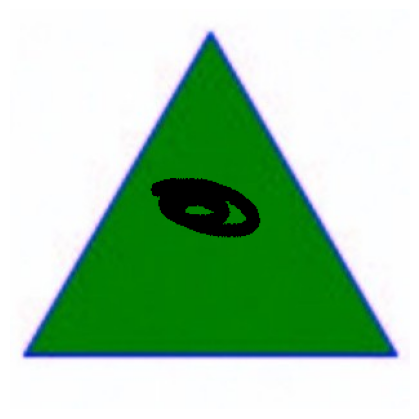

C:\Users\yacin\AppData\Local\Temp\ipykernel_20256\2012038109.py:13: RuntimeWarning: invalid value encountered in scalar divide
  coordx[i][j] = a/np.sqrt(a**2+b**2)
C:\Users\yacin\AppData\Local\Temp\ipykernel_20256\2012038109.py:14: RuntimeWarning: invalid value encountered in scalar divide
  coordy[i][j] = b/np.sqrt(a**2+b**2)
c:\Users\yacin\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\quiver.py:630: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
c:\Users\yacin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\yacin\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\quiver.py:632: RuntimeWarning: Mean of empty slice.
  amean = a.mean()


In [ ]:
inpainting('images/triangle.jpg', 'triangle006', patch_size=6, voisinage=False, initial_mask=triangle_mask)

In [ ]:
stop2 = iio.imread('images/stop2.jpg')
stop2_mask = mask_creation(stop2, 400, 493 , 245, 350)
view(apply_mask(stop2,stop2_mask))
frt=detection_de_bords(stop2_mask)
print(frt)

In [ ]:
stop2 = iio.imread('images/stop2.jpg')
stop2_mask = mask_creation(stop2, 340, 440 , 245, 350)
view(apply_mask(stop2,stop2_mask))
inpainting('images/stop2.jpg', 'stop2', patch_size=20, voisinage=False, initial_mask=stop2_mask)

In [ ]:
caree = iio.imread('images/mask.jpg')
mask_caree = mask_creation(caree, 105, 145 , 80, 105)
inpainting('images/mask.jpg', 'mask.jpg', patch_size=12, voisinage=False, initial_mask=mask_caree)

In [ ]:
mask_caree = mask_creation(caree, 80, 170 , 60, 180)
inpainting('images/mask.jpg', "caree", 6, True, initial_mask = mask_caree)

In [ ]:
beach = iio.imread('images/beach.jpg')
mask_beach = create_freehand_mask(beach)
view(mask_beach)
view(apply_mask(beach, mask_beach))

In [ ]:
inpainting("images/ile.png", "ile", patch_size = 24, voisinage=True)

In [ ]:
ovale = cv2.imread('images/ovale.jpg')
mask_ovale = create_freehand_mask(ovale)
print(mask_ovale.shape)
view(mask_ovale)

In [ ]:
inpainting("images/ovale.jpg", "ovale", patch_size = 8, voisinage=True, initial_mask = mask_ovale)

In [ ]:
inpainting("images/triangle.jpg", "triangle", patch_size = 7, voisinage=True)

In [ ]:
inpainting("images/texture_rose_jaune.jpg", "texture_rose_jaune", patch_size = 32, voisinage=True)

In [ ]:
inpainting("images/amodale2.jpg", "amodal2", patch_size = 8, voisinage=False)

In [ ]:
inpainting('images/arbre.jpg', "arbre.jpg", patch_size=9, voisinage=True)

In [ ]:
balle_verte = cv2.imread('images/article_image7.jpg')
masque_balle_verte = create_freehand_mask(balle_verte)

In [ ]:
inpainting('images/article_image7.jpg', "balleverte", patch_size=6, voisinage=False, initial_mask=masque_balle_verte)

In [ ]:
inpainting('images/statue.jpg', "statue", 6, True)

In [ ]:
poteau = cv2.imread('images/poteau.jpg')
mask_poteau = create_freehand_mask(poteau)

In [ ]:
inpainting("images/poteau.jpg", "poteau", patch_size = 14, voisinage=False, initial_mask = mask_poteau)

In [ ]:
inpainting('images/stop3.jpg', "stop3", 10, True)

In [ ]:
inpainting('images/rainbow.jpg', "rainbow", 14, False)

In [ ]:
inpainting('images/handwriting.jpg', "handwriting", 14, False)

In [ ]:
inpainting('images/poom.png', "poom", 10, False)

In [ ]:
inpainting('images/article_image5.jpg', "japanese", 6, False)

In [ ]:
poteau2 = cv2.imread('images/poteau2.jpg')
mask_poteau2 = create_freehand_mask(poteau2)

In [ ]:
inpainting('images/poteau2.jpg', "poteau2", 10, False, mask_poteau2)

In [ ]:
femme = cv2.imread('images/femme.jpg')  
mask_femme = create_freehand_mask(femme)

In [ ]:
inpainting(femme, "femme", 10, False, mask_femme)

In [ ]:
fruits = cv2.imread('images/fruits.jpg')
mask_fruits = create_freehand_mask(fruits)

In [ ]:
inpainting('images/fruits.jpg', "fruits", 6, False, mask_fruits)

In [ ]:
diver = cv2.imread('images/article_image4.jpg')
diver_mask = create_freehand_mask(diver)

In [ ]:
inpainting('images/article_image4.jpg', "diver", 14, False, diver_mask)

In [ ]:
inpainting('images/saumon.jpg', "saumon", 16, False)